In [1]:
import numpy as np
import time
import copy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.multivariate_normal import MultivariateNormal

import gym
import pybullet
import pybulletgym.envs

from collections import deque
from operator import itemgetter
from statistics import mean
from tqdm import tqdm

import matplotlib.pyplot as plt

def weighSync(target_model, source_model, tau=0.001):
    ''' A function to soft update target networks '''
    assert isinstance(tau, float) and tau>0

    for param_target, param_source in zip(target_model.parameters(), source_model.parameters()):
        # Wrap in torch.no_grad() because weights have requires_grad=True, 
        # but we don't need to track this in autograd
        with torch.no_grad():
            param_target = tau*param_source + (1-tau)*param_target
    
    return target_model, source_model


class Replay():
    def __init__(self, buffer_size, init_length, state_dim, action_dim, env):
        """
        A function to initialize the replay buffer.

        param: init_length : Initial number of transitions to collect
        param: state_dim : Size of the state space
        param: action_dim : Size of the action space
        param: env : gym environment object
        """
        assert isinstance(buffer_size, int) and buffer_size>0
        assert isinstance(init_length, int) and init_length>0
        assert isinstance(state_dim, int) and state_dim>0
        assert isinstance(action_dim, int) and action_dim>0
        
        self.buffer_size = buffer_size
        self.state_dim = state_dim
        self.action_dim = action_dim
        
        self.buffer = deque() #list like object for which removing elements from left is faster
        
        s = env.reset()
        for i in range(init_length):
            a = env.action_space.sample()
            s_prime, r, done, _ = env.step(a)
            self.buffer.append({
                's': s,
                'a': a,
                'r': r,
                's_prime': s_prime
            })
    
    def __len__(self):
        ''' Return number of elements in buffer'''
        return len(self.buffer)

    def buffer_add(self, exp):
        """
        A function to add a dictionary to the buffer
        param: exp : A dictionary consisting of state, action, reward , next state and done flag
        """
        assert isinstance(exp, dict) and len(exp) == 4
        assert len(self.buffer) <= self.buffer_size, 'Buffer size exceeded. You fucked up'
        
        if len(self.buffer) < self.buffer_size:
            self.buffer.append(exp)
        else:
            self.buffer.popleft() #removing the 1st element (left most element)
            self.buffer.append(exp)

    def buffer_sample(self, N):
        """
        A function to sample N points from the buffer
        param: N : Number of samples to obtain from the buffer
        """
        assert isinstance(N, int) and N>0
        indices = list(np.random.randint(low=0, high=len(self.buffer), size=N, dtype='int'))
        sample = itemgetter(*indices)(self.buffer) #extarct values at indices from buffer
        
        return sample


class Actor(nn.Module):
    #TODO: Complete the function
    def __init__(self, state_dim, action_dim):
        """
        Initialize the network
        param: state_dim : Size of the state space
        param: action_dim: Size of the action space
        """
        assert isinstance(state_dim, int) and state_dim>0
        assert isinstance(action_dim, int) and action_dim>0
        
        super(Actor, self).__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim
        
        # NN layers and activations
        self.fc1 = nn.Linear(state_dim, 400)
        self.hidden1 = nn.Linear(400, 300)
        self.fc2 = nn.Linear(300, action_dim)
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()

    def forward(self, state):
        """
        Define the forward pass
        param: state: The state of the environment
        """
#         assert isinstance(state, torch.Tensor)
        assert state.shape == (self.state_dim, ), 'state must be 1D and of size (%d,)'%self.state_dim
        
        if not(isinstance(state, torch.Tensor)):
            state = torch.from_numpy(state).float()
        
        x = state
        x = self.relu(self.fc1(x))
        x = self.relu(self.hidden1(x))
        x = self.tanh(self.fc2(x))

        return x
    
    def getAction(self, state, add_noise_flag = False, noise = 0.1):
        '''
        Returns an action by doing a forward pass. If add_noise_flag is True, 
        action is sampled from a multivariate Normal distributio with stddev = noise and mean = output of net
        
        :rtype: np.ndarray
        '''
#         print('type(state), shape = ',type(state), state.shape)
#         print('self.state_dim = ', self.state_dim)
        assert isinstance(state, np.ndarray)
        assert state.shape == (self.state_dim, )
        assert isinstance(noise, (int, float)) and noise >=0
        assert isinstance(add_noise_flag, bool)
        
        state = torch.from_numpy(state).float()
        action = self.forward(state) #forward pass
        
        if add_noise_flag:
            # Sampling from the nD Gaussian
            m = MultivariateNormal(action, torch.eye(self.action_dim)*noise)
            action = m.sample()
        
        return action.detach().squeeze().numpy()


class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        """
        Initialize the critic
        param: state_dim : Size of the state space
        param: action_dim : Size of the action space
        """
        assert isinstance(state_dim, int) and state_dim>0
        assert isinstance(action_dim, int) and action_dim>0
        
        super(Critic, self).__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim
        
        # NN layers and activations
        self.fc1 = nn.Linear(state_dim + action_dim, 400)
        self.hidden1 = nn.Linear(400, 300)
        self.fc2 = nn.Linear(300, 1)
        self.relu = nn.ReLU()

    def forward(self, state, action):
        """ Define the forward pass of the critic """
        assert isinstance(state, np.ndarray)
        assert isinstance(action, np.ndarray)
        assert state.shape == (self.state_dim, ), 'state must be 1D and of size (%d,)'%self.state_dim
        assert action.shape == (self.action_dim, ), 'action must be 1D and of size (%d,)'%self.action_dim
        
        state, action = torch.from_numpy(state).float(), torch.from_numpy(action).float() #numpy to torch tensor
        x = torch.cat((state, action), dim=0) #concatenating to form input
        x = self.relu(self.fc1(x))
        x = self.relu(self.hidden1(x))
        x = self.fc2(x)
        
        return x


class DDPG():
    def __init__(
            self,
            env,
            test_env,
            state_dim,    
            action_dim,
            critic_lr=3e-4,
            actor_lr=3e-4,
            gamma=0.99,
            batch_size=100,
            ev_n_steps=100,
            verbose=False
    ):
        """
        Implementing DPPG algorithm from paper - Continuous control with deep reinforcement learning
        link - https://arxiv.org/pdf/1509.02971.pdf
        
        param: env: An gym environment
        param: action_dim: Size of action space
        param: state_dim: Size of state space
        param: critic_lr: Learning rate of the critic
        param: actor_lr: Learning rate of the actor
        param: gamma: The discount factor
        param: batch_size: The batch size for training
        """

        assert isinstance(state_dim, int) and state_dim>0
        assert isinstance(action_dim, int) and action_dim>0
        assert isinstance(batch_size, int) and batch_size>0
        assert isinstance(critic_lr, (int, float)) and critic_lr>0
        assert isinstance(actor_lr, (int, float)) and actor_lr>0
        assert isinstance(gamma, (int, float)) and gamma>0
        assert isinstance(ev_n_steps, (int, float)) and ev_n_steps>0

        self.gamma = gamma
        self.batch_size = batch_size
        self.ev_n_steps = ev_n_steps
        self.env = env
        self.test_env = test_env
        self.num_episodes = 0
        self.avg_rewards = []
        self.obj_actor = []
        self.loss_critic = []

        # Create a actor and actor_target with same initial weights
        self.actor = Actor(state_dim, action_dim)
        self.actor = self.init_weights(self.actor) #initialize weights according to paper
        self.actor_target = copy.deepcopy(self.actor) #both networks have the same initial weights 

        # Create a critic and critic_target with same initial weights
        self.critic = Critic(state_dim, action_dim)
        self.critic = self.init_weights(self.critic) #initialize weights according to paper
        self.critic_target = copy.deepcopy(self.critic) #both networks have the same initial weights 

        # Define optimizer for actor and critic
        self.optimizer_actor = optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.optimizer_critic = optim.Adam(self.critic.parameters(), lr=critic_lr)
        self.loss_fn = nn.MSELoss(reduction='sum')

        # Define a replay buffer
        self.ReplayBuffer = Replay(10000, 1000, state_dim, action_dim, self.env)
    
    def init_weights(self, network):
        '''
        Initialize weights (as mentioned in paper) from a uniform distribution 
        based on the fan-in of the layer
        
        WARNING: Will only work if each layer is fully connected
        '''
        
        for name, param in network.named_parameters():
            if 'bias' in name: #if bias param, use f of the same layer
                f = last_f
            else:
                f = param.shape[1] #picking 2nd dim = number of inputs for that layer
                last_f = f
            # Initialize weights by sampling from uniform dist.
            assert isinstance(f, int) and f>0, 'fan in must be int and greater than 0'
            nn.init.uniform_(param.data, a = -1/np.sqrt(f), b = 1/np.sqrt(f))
#             nn.init.uniform_(param.data, a = 0.9999, b = 1)
        
        return network
    
    def save_actor(self, index):
        ''' Saves the policy NN'''
        filename = 'q1_policy_' + str(index) + '.pth.tar'
        state = { 'state_dict': self.actor.state_dict(),
                 'optimizer': self.optimizer_actor.state_dict() }
        torch.save(state, filename)
        
    def save_critic(self, index):
        ''' Saves the critic NN'''
        filename = 'q1_critic_' + str(index) + '.pth.tar'
        state = { 'state_dict': self.critic.state_dict(),
                 'optimizer': self.optimizer_critic.state_dict() }
        torch.save(state, filename)
    
    def update_target_networks(self):
        """
        A function to update the target networks
        """
        weighSync(self.actor_target, self.actor)
        weighSync(self.critic_target, self.critic)

    def update_network(self):
        """
        A function to update the function just once
        """
        pass
    
    def getAverageReward(self):
        ''' Run the policy and return average reward '''
        rewards = []
        s = self.test_env.reset()
        done = False
        while not(done):
            a = self.actor(s).detach().squeeze().numpy()
            s, r, done, _ = self.test_env.step(a)
            rewards.append(r)
        
        avg_reward = sum(rewards)
        assert isinstance(avg_reward, (int, float))
        
        return avg_reward

    def train(self, max_num_steps):
        """
        Train the policy for the given number of iterations
        :param num_steps:The number of steps to train the policy for
        """
        assert isinstance(max_num_steps, int) and max_num_steps>0
        
        gamma = self.gamma
        s = self.env.reset()
        done = False
        for num_steps in tqdm(range(max_num_steps)):
            # Reset env when it reached terminal state
            if done:
                self.num_episodes += 1
                s = self.env.reset()
            
            a = self.actor.getAction(s, add_noise_flag = True, noise = 0.1)
            s_prime, r, done, _ = self.env.step(a)
            
            # Storing transition in buffer
            self.ReplayBuffer.buffer_add({
                's': s,
                'a': a,
                'r': r,
                's_prime': s_prime
            })
            # Sampling N points from buffer
            minibatch = self.ReplayBuffer.buffer_sample(N = self.batch_size)
            
            loss_critic = torch.tensor([0]).float()
            obj_actor = torch.tensor([0]).float()
            
            # Operating on minibatch
            for sample in minibatch:
                s, a, r, s_prime = sample['s'], sample['a'], sample['r'], sample['s_prime']
                # Calculating critic loss
                a_target = self.actor_target.getAction(s_prime, add_noise_flag=False)
                y_i = r + gamma*self.critic_target(s_prime, a_target)
                loss_critic = self.loss_fn(self.critic(s,a), y_i) #mse loss
                
                # Calculating actor loss
                a = self.actor.getAction(s_prime, add_noise_flag=False)
                obj_actor += self.critic(s, a)
            
            # Zero gradients of optimizer
            self.optimizer_critic.zero_grad()    
            self.optimizer_actor.zero_grad()
            # Update critic
            loss_critic.backward()
            self.optimizer_critic.step()
            # Update actor
            obj_actor /= -self.batch_size #multiplying with negative so it does gradient ascent
            obj_actor.backward()
            self.optimizer_actor.step()
            # Update target networks
            self.update_target_networks()
            
            # Store losses
            self.obj_actor.append(obj_actor.item())
            self.loss_critic.append(loss_critic.item())
            
            if num_steps%self.ev_n_steps == 0:
                r = self.getAverageReward()
                self.avg_rewards.append(r)
                if verbose:
                    print('Num steps: {0} \t Avg Reward: {1:.3f} \t Obj(Actor): {2:.3f} \t Loss(Critic): {3:.3f}'
                          .format(num_steps, r, obj_actor.item(), loss_critic.item()))
                
            

In [2]:
if __name__ == "__main__":
    
    # Seed values
    torch.manual_seed(420)
    
    # Define the environment
    env = gym.make("modified_gym_env:ReacherPyBulletEnv-v1", rand_init=True)
    test_env = copy.deepcopy(env)
    plot = True
    verbose = True
    
    # Define Deep Deterministic Policy Gradient object
    ddpg_object = DDPG(
        env,
        test_env,
        8,
        2,
        critic_lr=1e-3,
        actor_lr=1e-4,
        gamma=0.99,
        batch_size=100,
        ev_n_steps=200, #evaluate every n steps
        verbose=verbose
    )
    # Train the policy
    ddpg_object.train(int(1e5))

current_dir=/Users/adnanshahpurwala/anaconda3/envs/ece276c_venv/lib/python3.6/site-packages/pybullet_envs/bullet
options= 


  0%|          | 2/100000 [00:00<5:23:37,  5.15it/s]

options= 
Num steps: 0 	 Avg Reward: -27.571 	 Obj(Actor): -0.065 	 Loss(Critic): 0.035


  0%|          | 202/100000 [00:25<3:53:58,  7.11it/s]

Num steps: 200 	 Avg Reward: -22.056 	 Obj(Actor): -0.572 	 Loss(Critic): 0.106


  0%|          | 402/100000 [00:50<3:49:34,  7.23it/s]

Num steps: 400 	 Avg Reward: -25.079 	 Obj(Actor): -0.912 	 Loss(Critic): 5.249


  1%|          | 602/100000 [01:14<3:41:29,  7.48it/s]

Num steps: 600 	 Avg Reward: -28.244 	 Obj(Actor): -0.859 	 Loss(Critic): 0.781


  1%|          | 802/100000 [01:39<3:51:35,  7.14it/s]

Num steps: 800 	 Avg Reward: -18.077 	 Obj(Actor): -0.777 	 Loss(Critic): 0.254


  1%|          | 1002/100000 [02:04<3:32:44,  7.76it/s]

Num steps: 1000 	 Avg Reward: -0.008 	 Obj(Actor): -0.519 	 Loss(Critic): 0.017


  1%|          | 1202/100000 [02:29<3:40:30,  7.47it/s]

Num steps: 1200 	 Avg Reward: -13.178 	 Obj(Actor): -0.278 	 Loss(Critic): 0.008


  1%|▏         | 1402/100000 [02:54<3:47:28,  7.22it/s]

Num steps: 1400 	 Avg Reward: -18.664 	 Obj(Actor): -0.721 	 Loss(Critic): 1.755


  2%|▏         | 1602/100000 [03:20<3:51:38,  7.08it/s]

Num steps: 1600 	 Avg Reward: -24.634 	 Obj(Actor): -0.330 	 Loss(Critic): 0.153


  2%|▏         | 1802/100000 [03:45<3:50:47,  7.09it/s]

Num steps: 1800 	 Avg Reward: -14.191 	 Obj(Actor): -0.310 	 Loss(Critic): 0.201


  2%|▏         | 2002/100000 [04:11<3:52:22,  7.03it/s]

Num steps: 2000 	 Avg Reward: -11.559 	 Obj(Actor): -0.182 	 Loss(Critic): 0.100


  2%|▏         | 2202/100000 [04:36<3:53:17,  6.99it/s]

Num steps: 2200 	 Avg Reward: -28.026 	 Obj(Actor): 0.030 	 Loss(Critic): 1.795


  2%|▏         | 2402/100000 [05:02<3:50:41,  7.05it/s]

Num steps: 2400 	 Avg Reward: -24.219 	 Obj(Actor): -0.055 	 Loss(Critic): 0.069


  3%|▎         | 2602/100000 [05:27<3:43:41,  7.26it/s]

Num steps: 2600 	 Avg Reward: -23.626 	 Obj(Actor): -0.064 	 Loss(Critic): 0.090


  3%|▎         | 2802/100000 [05:52<3:44:18,  7.22it/s]

Num steps: 2800 	 Avg Reward: -25.947 	 Obj(Actor): -0.256 	 Loss(Critic): 0.377


  3%|▎         | 3002/100000 [06:17<3:44:25,  7.20it/s]

Num steps: 3000 	 Avg Reward: -22.577 	 Obj(Actor): -0.069 	 Loss(Critic): 0.102


  3%|▎         | 3202/100000 [06:43<3:33:07,  7.57it/s]

Num steps: 3200 	 Avg Reward: -14.195 	 Obj(Actor): -0.054 	 Loss(Critic): 0.092


  3%|▎         | 3402/100000 [07:08<3:31:30,  7.61it/s]

Num steps: 3400 	 Avg Reward: -13.559 	 Obj(Actor): 0.017 	 Loss(Critic): 0.036


  4%|▎         | 3602/100000 [07:34<3:44:59,  7.14it/s]

Num steps: 3600 	 Avg Reward: -25.575 	 Obj(Actor): -0.049 	 Loss(Critic): 0.006


  4%|▍         | 3802/100000 [07:59<3:47:10,  7.06it/s]

Num steps: 3800 	 Avg Reward: -24.256 	 Obj(Actor): -0.148 	 Loss(Critic): 29.117


  4%|▍         | 4002/100000 [08:25<3:45:30,  7.09it/s]

Num steps: 4000 	 Avg Reward: -13.688 	 Obj(Actor): -0.076 	 Loss(Critic): 0.012


  4%|▍         | 4202/100000 [08:50<3:41:21,  7.21it/s]

Num steps: 4200 	 Avg Reward: -20.245 	 Obj(Actor): -0.032 	 Loss(Critic): 0.039


  4%|▍         | 4402/100000 [09:16<3:43:40,  7.12it/s]

Num steps: 4400 	 Avg Reward: -22.076 	 Obj(Actor): -0.132 	 Loss(Critic): 0.026


  5%|▍         | 4602/100000 [09:41<3:45:59,  7.04it/s]

Num steps: 4600 	 Avg Reward: -26.505 	 Obj(Actor): -0.286 	 Loss(Critic): 0.060


  5%|▍         | 4802/100000 [10:07<3:46:57,  6.99it/s]

Num steps: 4800 	 Avg Reward: -21.688 	 Obj(Actor): -0.178 	 Loss(Critic): 1.382


  5%|▌         | 5002/100000 [10:32<3:45:05,  7.03it/s]

Num steps: 5000 	 Avg Reward: -25.099 	 Obj(Actor): -0.031 	 Loss(Critic): 0.047


  5%|▌         | 5202/100000 [10:57<3:39:06,  7.21it/s]

Num steps: 5200 	 Avg Reward: -26.122 	 Obj(Actor): -0.049 	 Loss(Critic): 0.002


  5%|▌         | 5402/100000 [11:23<3:38:12,  7.23it/s]

Num steps: 5400 	 Avg Reward: -23.928 	 Obj(Actor): 0.010 	 Loss(Critic): 0.362


  6%|▌         | 5602/100000 [11:48<3:33:15,  7.38it/s]

Num steps: 5600 	 Avg Reward: -10.886 	 Obj(Actor): -0.119 	 Loss(Critic): 0.020


  6%|▌         | 5802/100000 [12:13<3:40:31,  7.12it/s]

Num steps: 5800 	 Avg Reward: -24.913 	 Obj(Actor): -0.132 	 Loss(Critic): 0.016


  6%|▌         | 6002/100000 [12:39<3:20:40,  7.81it/s]

Num steps: 6000 	 Avg Reward: -0.053 	 Obj(Actor): 0.157 	 Loss(Critic): 0.005


  6%|▌         | 6202/100000 [13:04<3:37:06,  7.20it/s]

Num steps: 6200 	 Avg Reward: -25.538 	 Obj(Actor): -0.031 	 Loss(Critic): 0.027


  6%|▋         | 6402/100000 [13:30<3:50:51,  6.76it/s]

Num steps: 6400 	 Avg Reward: -23.543 	 Obj(Actor): -0.079 	 Loss(Critic): 0.018


  7%|▋         | 6602/100000 [13:55<3:38:55,  7.11it/s]

Num steps: 6600 	 Avg Reward: -26.827 	 Obj(Actor): -0.048 	 Loss(Critic): 0.061


  7%|▋         | 6802/100000 [14:20<3:25:32,  7.56it/s]

Num steps: 6800 	 Avg Reward: -13.727 	 Obj(Actor): -0.063 	 Loss(Critic): 0.038


  7%|▋         | 7002/100000 [14:46<3:39:54,  7.05it/s]

Num steps: 7000 	 Avg Reward: -21.343 	 Obj(Actor): 0.027 	 Loss(Critic): 1.646


  7%|▋         | 7202/100000 [15:11<3:34:35,  7.21it/s]

Num steps: 7200 	 Avg Reward: -13.441 	 Obj(Actor): -0.000 	 Loss(Critic): 0.001


  7%|▋         | 7402/100000 [15:37<3:34:56,  7.18it/s]

Num steps: 7400 	 Avg Reward: -21.893 	 Obj(Actor): 0.038 	 Loss(Critic): 0.205


  8%|▊         | 7602/100000 [16:03<3:38:46,  7.04it/s]

Num steps: 7600 	 Avg Reward: -22.085 	 Obj(Actor): 0.080 	 Loss(Critic): 0.001


  8%|▊         | 7802/100000 [16:28<3:37:16,  7.07it/s]

Num steps: 7800 	 Avg Reward: -22.109 	 Obj(Actor): -0.005 	 Loss(Critic): 0.013


  8%|▊         | 8002/100000 [16:56<3:50:03,  6.66it/s]

Num steps: 8000 	 Avg Reward: -23.208 	 Obj(Actor): 0.023 	 Loss(Critic): 0.007


  8%|▊         | 8202/100000 [17:25<5:02:25,  5.06it/s]

Num steps: 8200 	 Avg Reward: -23.829 	 Obj(Actor): -0.043 	 Loss(Critic): 0.000


  8%|▊         | 8402/100000 [17:59<5:20:29,  4.76it/s]

Num steps: 8400 	 Avg Reward: -23.550 	 Obj(Actor): 0.032 	 Loss(Critic): 0.002


  9%|▊         | 8602/100000 [18:34<4:46:31,  5.32it/s]

Num steps: 8600 	 Avg Reward: -20.787 	 Obj(Actor): 0.014 	 Loss(Critic): 0.075


  9%|▉         | 8802/100000 [19:09<4:51:29,  5.21it/s]

Num steps: 8800 	 Avg Reward: -23.929 	 Obj(Actor): 0.028 	 Loss(Critic): 0.001


  9%|▉         | 9002/100000 [19:44<4:50:55,  5.21it/s]

Num steps: 9000 	 Avg Reward: -22.491 	 Obj(Actor): 0.032 	 Loss(Critic): 0.006


  9%|▉         | 9202/100000 [20:19<4:49:41,  5.22it/s]

Num steps: 9200 	 Avg Reward: -22.552 	 Obj(Actor): 0.045 	 Loss(Critic): 0.002


  9%|▉         | 9402/100000 [20:55<4:39:43,  5.40it/s]

Num steps: 9400 	 Avg Reward: -22.657 	 Obj(Actor): 0.021 	 Loss(Critic): 0.010


 10%|▉         | 9602/100000 [21:31<4:51:42,  5.16it/s]

Num steps: 9600 	 Avg Reward: -24.656 	 Obj(Actor): 0.043 	 Loss(Critic): 0.030


 10%|▉         | 9801/100000 [22:07<5:02:52,  4.96it/s]

Num steps: 9800 	 Avg Reward: -24.680 	 Obj(Actor): 0.054 	 Loss(Critic): 0.000


 10%|█         | 10002/100000 [22:42<5:02:10,  4.96it/s]

Num steps: 10000 	 Avg Reward: -24.423 	 Obj(Actor): 0.086 	 Loss(Critic): 0.065


 10%|█         | 10202/100000 [23:15<4:59:00,  5.01it/s]

Num steps: 10200 	 Avg Reward: -27.078 	 Obj(Actor): 0.107 	 Loss(Critic): 0.001


 10%|█         | 10402/100000 [23:48<4:27:07,  5.59it/s]

Num steps: 10400 	 Avg Reward: -19.780 	 Obj(Actor): 0.113 	 Loss(Critic): 0.017


 11%|█         | 10602/100000 [24:22<4:30:33,  5.51it/s]

Num steps: 10600 	 Avg Reward: -27.946 	 Obj(Actor): 0.102 	 Loss(Critic): 0.001


 11%|█         | 10802/100000 [24:56<4:06:29,  6.03it/s]

Num steps: 10800 	 Avg Reward: -0.007 	 Obj(Actor): 0.072 	 Loss(Critic): 0.000


 11%|█         | 11002/100000 [25:29<4:22:40,  5.65it/s]

Num steps: 11000 	 Avg Reward: -24.622 	 Obj(Actor): 0.105 	 Loss(Critic): 0.005


 11%|█         | 11202/100000 [26:04<4:29:11,  5.50it/s]

Num steps: 11200 	 Avg Reward: -24.899 	 Obj(Actor): 0.084 	 Loss(Critic): 0.002


 11%|█▏        | 11402/100000 [26:39<5:08:14,  4.79it/s]

Num steps: 11400 	 Avg Reward: -24.687 	 Obj(Actor): 0.098 	 Loss(Critic): 0.026


 12%|█▏        | 11602/100000 [27:11<3:44:28,  6.56it/s]

Num steps: 11600 	 Avg Reward: -21.935 	 Obj(Actor): 0.084 	 Loss(Critic): 0.075


 12%|█▏        | 11802/100000 [27:41<3:57:52,  6.18it/s]

Num steps: 11800 	 Avg Reward: -17.256 	 Obj(Actor): 0.081 	 Loss(Critic): 0.001


 12%|█▏        | 12002/100000 [28:10<3:27:01,  7.08it/s]

Num steps: 12000 	 Avg Reward: -13.788 	 Obj(Actor): 0.091 	 Loss(Critic): 0.001


 12%|█▏        | 12202/100000 [28:38<3:32:15,  6.89it/s]

Num steps: 12200 	 Avg Reward: -22.640 	 Obj(Actor): 0.091 	 Loss(Critic): 0.001


 12%|█▏        | 12402/100000 [29:06<3:34:41,  6.80it/s]

Num steps: 12400 	 Avg Reward: -24.982 	 Obj(Actor): 0.078 	 Loss(Critic): 0.009


 13%|█▎        | 12602/100000 [29:33<3:29:59,  6.94it/s]

Num steps: 12600 	 Avg Reward: -25.312 	 Obj(Actor): 0.097 	 Loss(Critic): 0.004


 13%|█▎        | 12802/100000 [30:01<3:45:47,  6.44it/s]

Num steps: 12800 	 Avg Reward: -23.509 	 Obj(Actor): 0.087 	 Loss(Critic): 0.000


 13%|█▎        | 13002/100000 [30:28<3:28:47,  6.94it/s]

Num steps: 13000 	 Avg Reward: -19.780 	 Obj(Actor): 0.080 	 Loss(Critic): 0.002


 13%|█▎        | 13202/100000 [30:54<3:24:54,  7.06it/s]

Num steps: 13200 	 Avg Reward: -22.860 	 Obj(Actor): 0.111 	 Loss(Critic): 0.001


 13%|█▎        | 13402/100000 [31:20<3:23:10,  7.10it/s]

Num steps: 13400 	 Avg Reward: -27.725 	 Obj(Actor): 0.087 	 Loss(Critic): 0.001


 14%|█▎        | 13602/100000 [31:46<3:25:10,  7.02it/s]

Num steps: 13600 	 Avg Reward: -26.259 	 Obj(Actor): 0.100 	 Loss(Critic): 0.003


 14%|█▍        | 13802/100000 [32:12<3:26:44,  6.95it/s]

Num steps: 13800 	 Avg Reward: -23.706 	 Obj(Actor): 0.095 	 Loss(Critic): 0.000


 14%|█▍        | 14002/100000 [32:37<3:06:12,  7.70it/s]

Num steps: 14000 	 Avg Reward: -0.006 	 Obj(Actor): 0.105 	 Loss(Critic): 0.001


 14%|█▍        | 14202/100000 [33:03<3:26:03,  6.94it/s]

Num steps: 14200 	 Avg Reward: -23.411 	 Obj(Actor): 0.090 	 Loss(Critic): 0.001


 14%|█▍        | 14402/100000 [33:28<3:01:58,  7.84it/s]

Num steps: 14400 	 Avg Reward: -0.005 	 Obj(Actor): 0.100 	 Loss(Critic): 0.001


 15%|█▍        | 14602/100000 [33:54<3:19:27,  7.14it/s]

Num steps: 14600 	 Avg Reward: -18.930 	 Obj(Actor): 0.092 	 Loss(Critic): 0.016


 15%|█▍        | 14802/100000 [34:20<3:20:50,  7.07it/s]

Num steps: 14800 	 Avg Reward: -22.694 	 Obj(Actor): 0.098 	 Loss(Critic): 0.001


 15%|█▌        | 15002/100000 [34:45<3:20:08,  7.08it/s]

Num steps: 15000 	 Avg Reward: -21.868 	 Obj(Actor): 0.094 	 Loss(Critic): 0.021


 15%|█▌        | 15202/100000 [35:11<3:15:36,  7.23it/s]

Num steps: 15200 	 Avg Reward: -12.203 	 Obj(Actor): 0.081 	 Loss(Critic): 0.001


 15%|█▌        | 15402/100000 [35:37<3:20:42,  7.03it/s]

Num steps: 15400 	 Avg Reward: -21.403 	 Obj(Actor): 0.096 	 Loss(Critic): 0.005


 16%|█▌        | 15602/100000 [36:03<3:13:02,  7.29it/s]

Num steps: 15600 	 Avg Reward: -13.559 	 Obj(Actor): 0.094 	 Loss(Critic): 0.002


 16%|█▌        | 15802/100000 [36:28<3:15:11,  7.19it/s]

Num steps: 15800 	 Avg Reward: -25.027 	 Obj(Actor): 0.091 	 Loss(Critic): 0.017


 16%|█▌        | 16002/100000 [36:54<2:59:32,  7.80it/s]

Num steps: 16000 	 Avg Reward: -0.088 	 Obj(Actor): 0.102 	 Loss(Critic): 0.022


 16%|█▌        | 16202/100000 [37:19<3:16:50,  7.10it/s]

Num steps: 16200 	 Avg Reward: -21.602 	 Obj(Actor): 0.106 	 Loss(Critic): 0.002


 16%|█▋        | 16402/100000 [37:45<2:55:45,  7.93it/s]

Num steps: 16400 	 Avg Reward: -0.004 	 Obj(Actor): 0.088 	 Loss(Critic): 0.007


 17%|█▋        | 16602/100000 [38:10<3:02:05,  7.63it/s]

Num steps: 16600 	 Avg Reward: -0.008 	 Obj(Actor): 0.102 	 Loss(Critic): 0.003


 17%|█▋        | 16802/100000 [38:36<3:17:10,  7.03it/s]

Num steps: 16800 	 Avg Reward: -20.318 	 Obj(Actor): 0.072 	 Loss(Critic): 0.000


 17%|█▋        | 17002/100000 [39:02<3:16:34,  7.04it/s]

Num steps: 17000 	 Avg Reward: -20.607 	 Obj(Actor): 0.075 	 Loss(Critic): 0.000


 17%|█▋        | 17202/100000 [39:28<4:33:07,  5.05it/s]

Num steps: 17200 	 Avg Reward: -27.204 	 Obj(Actor): 0.109 	 Loss(Critic): 0.025


 17%|█▋        | 17402/100000 [39:54<3:13:47,  7.10it/s]

Num steps: 17400 	 Avg Reward: -17.956 	 Obj(Actor): 0.090 	 Loss(Critic): 0.000


 18%|█▊        | 17602/100000 [40:20<3:04:50,  7.43it/s]

Num steps: 17600 	 Avg Reward: -14.193 	 Obj(Actor): 0.111 	 Loss(Critic): 0.003


 18%|█▊        | 17802/100000 [40:45<3:12:12,  7.13it/s]

Num steps: 17800 	 Avg Reward: -21.347 	 Obj(Actor): 0.101 	 Loss(Critic): 0.019


 18%|█▊        | 18002/100000 [41:11<3:10:24,  7.18it/s]

Num steps: 18000 	 Avg Reward: -23.763 	 Obj(Actor): 0.084 	 Loss(Critic): 0.002


 18%|█▊        | 18202/100000 [41:37<3:13:36,  7.04it/s]

Num steps: 18200 	 Avg Reward: -17.575 	 Obj(Actor): 0.095 	 Loss(Critic): 0.001


 18%|█▊        | 18402/100000 [42:02<3:12:50,  7.05it/s]

Num steps: 18400 	 Avg Reward: -23.429 	 Obj(Actor): 0.082 	 Loss(Critic): 0.009


 19%|█▊        | 18602/100000 [42:28<3:11:11,  7.10it/s]

Num steps: 18600 	 Avg Reward: -22.316 	 Obj(Actor): 0.078 	 Loss(Critic): 0.023


 19%|█▉        | 18802/100000 [42:53<3:10:14,  7.11it/s]

Num steps: 18800 	 Avg Reward: -20.360 	 Obj(Actor): 0.089 	 Loss(Critic): 0.012


 19%|█▉        | 19002/100000 [43:19<3:12:28,  7.01it/s]

Num steps: 19000 	 Avg Reward: -19.840 	 Obj(Actor): 0.088 	 Loss(Critic): 0.004


 19%|█▉        | 19202/100000 [43:45<3:08:41,  7.14it/s]

Num steps: 19200 	 Avg Reward: -23.894 	 Obj(Actor): 0.083 	 Loss(Critic): 0.000


 19%|█▉        | 19402/100000 [44:10<3:07:02,  7.18it/s]

Num steps: 19400 	 Avg Reward: -22.634 	 Obj(Actor): 0.079 	 Loss(Critic): 0.012


 20%|█▉        | 19602/100000 [44:36<3:08:33,  7.11it/s]

Num steps: 19600 	 Avg Reward: -25.446 	 Obj(Actor): 0.090 	 Loss(Critic): 0.002


 20%|█▉        | 19802/100000 [45:02<3:12:43,  6.94it/s]

Num steps: 19800 	 Avg Reward: -20.494 	 Obj(Actor): 0.084 	 Loss(Critic): 0.000


 20%|██        | 20002/100000 [45:27<3:08:28,  7.07it/s]

Num steps: 20000 	 Avg Reward: -22.240 	 Obj(Actor): 0.087 	 Loss(Critic): 0.046


 20%|██        | 20202/100000 [45:53<3:07:33,  7.09it/s]

Num steps: 20200 	 Avg Reward: -23.862 	 Obj(Actor): 0.100 	 Loss(Critic): 0.000


 20%|██        | 20402/100000 [46:18<3:07:35,  7.07it/s]

Num steps: 20400 	 Avg Reward: -20.133 	 Obj(Actor): 0.088 	 Loss(Critic): 0.000


 21%|██        | 20602/100000 [46:44<3:05:26,  7.14it/s]

Num steps: 20600 	 Avg Reward: -27.106 	 Obj(Actor): 0.095 	 Loss(Critic): 0.038


 21%|██        | 20802/100000 [47:10<3:04:14,  7.16it/s]

Num steps: 20800 	 Avg Reward: -12.319 	 Obj(Actor): 0.084 	 Loss(Critic): 0.000


 21%|██        | 21002/100000 [47:35<3:03:25,  7.18it/s]

Num steps: 21000 	 Avg Reward: -22.422 	 Obj(Actor): 0.095 	 Loss(Critic): 0.012


 21%|██        | 21202/100000 [48:02<3:19:18,  6.59it/s]

Num steps: 21200 	 Avg Reward: -22.085 	 Obj(Actor): 0.089 	 Loss(Critic): 0.001


 21%|██▏       | 21402/100000 [48:28<3:10:39,  6.87it/s]

Num steps: 21400 	 Avg Reward: -20.949 	 Obj(Actor): 0.085 	 Loss(Critic): 0.028


 22%|██▏       | 21602/100000 [48:56<3:03:26,  7.12it/s]

Num steps: 21600 	 Avg Reward: -9.821 	 Obj(Actor): 0.087 	 Loss(Critic): 0.038


 22%|██▏       | 21802/100000 [49:24<3:14:20,  6.71it/s]

Num steps: 21800 	 Avg Reward: -19.541 	 Obj(Actor): 0.085 	 Loss(Critic): 0.016


 22%|██▏       | 22002/100000 [49:54<3:23:50,  6.38it/s]

Num steps: 22000 	 Avg Reward: -13.356 	 Obj(Actor): 0.090 	 Loss(Critic): 0.019


 22%|██▏       | 22202/100000 [50:24<3:33:06,  6.08it/s]

Num steps: 22200 	 Avg Reward: -18.665 	 Obj(Actor): 0.082 	 Loss(Critic): 0.003


 22%|██▏       | 22402/100000 [50:53<3:17:55,  6.53it/s]

Num steps: 22400 	 Avg Reward: -23.092 	 Obj(Actor): 0.088 	 Loss(Critic): 0.000


 23%|██▎       | 22602/100000 [51:22<3:10:48,  6.76it/s]

Num steps: 22600 	 Avg Reward: -18.595 	 Obj(Actor): 0.097 	 Loss(Critic): 0.000


 23%|██▎       | 22802/100000 [51:50<3:05:39,  6.93it/s]

Num steps: 22800 	 Avg Reward: -20.462 	 Obj(Actor): 0.073 	 Loss(Critic): 0.019


 23%|██▎       | 23002/100000 [52:17<3:05:56,  6.90it/s]

Num steps: 23000 	 Avg Reward: -13.455 	 Obj(Actor): 0.086 	 Loss(Critic): 0.029


 23%|██▎       | 23202/100000 [52:44<3:15:41,  6.54it/s]

Num steps: 23200 	 Avg Reward: -20.230 	 Obj(Actor): 0.097 	 Loss(Critic): 0.003


 23%|██▎       | 23402/100000 [53:11<3:17:20,  6.47it/s]

Num steps: 23400 	 Avg Reward: -26.337 	 Obj(Actor): 0.086 	 Loss(Critic): 0.004


 24%|██▎       | 23602/100000 [53:38<3:16:22,  6.48it/s]

Num steps: 23600 	 Avg Reward: -23.890 	 Obj(Actor): 0.081 	 Loss(Critic): 0.000


 24%|██▍       | 23802/100000 [54:04<2:56:42,  7.19it/s]

Num steps: 23800 	 Avg Reward: -23.050 	 Obj(Actor): 0.094 	 Loss(Critic): 0.086


 24%|██▍       | 24002/100000 [54:31<3:11:32,  6.61it/s]

Num steps: 24000 	 Avg Reward: -26.103 	 Obj(Actor): 0.082 	 Loss(Critic): 0.000


 24%|██▍       | 24202/100000 [54:56<2:58:56,  7.06it/s]

Num steps: 24200 	 Avg Reward: -25.525 	 Obj(Actor): 0.091 	 Loss(Critic): 0.000


 24%|██▍       | 24402/100000 [55:22<2:51:16,  7.36it/s]

Num steps: 24400 	 Avg Reward: -11.672 	 Obj(Actor): 0.094 	 Loss(Critic): 0.009


 25%|██▍       | 24602/100000 [55:48<2:56:41,  7.11it/s]

Num steps: 24600 	 Avg Reward: -13.560 	 Obj(Actor): 0.079 	 Loss(Critic): 0.001


 25%|██▍       | 24802/100000 [56:13<2:56:38,  7.09it/s]

Num steps: 24800 	 Avg Reward: -18.410 	 Obj(Actor): 0.088 	 Loss(Critic): 0.007


 25%|██▌       | 25002/100000 [56:39<2:56:41,  7.07it/s]

Num steps: 25000 	 Avg Reward: -25.711 	 Obj(Actor): 0.085 	 Loss(Critic): 0.035


 25%|██▌       | 25202/100000 [57:04<2:39:11,  7.83it/s]

Num steps: 25200 	 Avg Reward: -0.006 	 Obj(Actor): 0.098 	 Loss(Critic): 0.000


 25%|██▌       | 25402/100000 [57:30<2:53:50,  7.15it/s]

Num steps: 25400 	 Avg Reward: -25.673 	 Obj(Actor): 0.100 	 Loss(Critic): 0.009


 26%|██▌       | 25602/100000 [57:56<2:54:18,  7.11it/s]

Num steps: 25600 	 Avg Reward: -23.803 	 Obj(Actor): 0.092 	 Loss(Critic): 0.002


 26%|██▌       | 25802/100000 [58:21<2:54:51,  7.07it/s]

Num steps: 25800 	 Avg Reward: -21.148 	 Obj(Actor): 0.097 	 Loss(Critic): 0.000


 26%|██▌       | 26002/100000 [58:47<2:59:52,  6.86it/s]

Num steps: 26000 	 Avg Reward: -26.279 	 Obj(Actor): 0.087 	 Loss(Critic): 0.002


 26%|██▌       | 26202/100000 [59:12<2:46:15,  7.40it/s]

Num steps: 26200 	 Avg Reward: -21.946 	 Obj(Actor): 0.088 	 Loss(Critic): 0.004


 26%|██▋       | 26402/100000 [59:38<2:52:18,  7.12it/s]

Num steps: 26400 	 Avg Reward: -27.718 	 Obj(Actor): 0.101 	 Loss(Critic): 0.013


 27%|██▋       | 26602/100000 [1:00:03<2:36:03,  7.84it/s]

Num steps: 26600 	 Avg Reward: -0.005 	 Obj(Actor): 0.066 	 Loss(Critic): 0.026


 27%|██▋       | 26802/100000 [1:00:29<2:50:47,  7.14it/s]

Num steps: 26800 	 Avg Reward: -23.106 	 Obj(Actor): 0.092 	 Loss(Critic): 0.020


 27%|██▋       | 27002/100000 [1:00:54<2:50:12,  7.15it/s]

Num steps: 27000 	 Avg Reward: -22.777 	 Obj(Actor): 0.101 	 Loss(Critic): 0.060


 27%|██▋       | 27202/100000 [1:01:20<2:50:13,  7.13it/s]

Num steps: 27200 	 Avg Reward: -23.826 	 Obj(Actor): 0.103 	 Loss(Critic): 0.000


 27%|██▋       | 27402/100000 [1:01:45<2:42:06,  7.46it/s]

Num steps: 27400 	 Avg Reward: -13.733 	 Obj(Actor): 0.089 	 Loss(Critic): 0.012


 28%|██▊       | 27602/100000 [1:02:11<3:01:05,  6.66it/s]

Num steps: 27600 	 Avg Reward: -22.251 	 Obj(Actor): 0.086 	 Loss(Critic): 0.000


 28%|██▊       | 27802/100000 [1:02:36<2:49:10,  7.11it/s]

Num steps: 27800 	 Avg Reward: -23.158 	 Obj(Actor): 0.087 	 Loss(Critic): 0.000


 28%|██▊       | 28002/100000 [1:03:02<2:51:49,  6.98it/s]

Num steps: 28000 	 Avg Reward: -23.936 	 Obj(Actor): 0.081 	 Loss(Critic): 0.018


 28%|██▊       | 28202/100000 [1:03:28<2:32:39,  7.84it/s]

Num steps: 28200 	 Avg Reward: -0.009 	 Obj(Actor): 0.087 	 Loss(Critic): 0.020


 28%|██▊       | 28402/100000 [1:03:53<2:47:14,  7.14it/s]

Num steps: 28400 	 Avg Reward: -27.125 	 Obj(Actor): 0.092 	 Loss(Critic): 0.000


 29%|██▊       | 28602/100000 [1:04:19<2:47:46,  7.09it/s]

Num steps: 28600 	 Avg Reward: -24.147 	 Obj(Actor): 0.099 	 Loss(Critic): 0.000


 29%|██▉       | 28802/100000 [1:04:44<2:31:04,  7.85it/s]

Num steps: 28800 	 Avg Reward: -0.005 	 Obj(Actor): 0.094 	 Loss(Critic): 0.001


 29%|██▉       | 29002/100000 [1:05:10<2:45:10,  7.16it/s]

Num steps: 29000 	 Avg Reward: -20.799 	 Obj(Actor): 0.094 	 Loss(Critic): 0.034


 29%|██▉       | 29202/100000 [1:05:35<2:43:48,  7.20it/s]

Num steps: 29200 	 Avg Reward: -25.779 	 Obj(Actor): 0.095 	 Loss(Critic): 0.000


 29%|██▉       | 29402/100000 [1:06:00<2:45:40,  7.10it/s]

Num steps: 29400 	 Avg Reward: -23.904 	 Obj(Actor): 0.088 	 Loss(Critic): 0.007


 30%|██▉       | 29602/100000 [1:06:26<2:41:32,  7.26it/s]

Num steps: 29600 	 Avg Reward: -18.925 	 Obj(Actor): 0.093 	 Loss(Critic): 0.042


 30%|██▉       | 29802/100000 [1:06:52<2:47:57,  6.97it/s]

Num steps: 29800 	 Avg Reward: -20.630 	 Obj(Actor): 0.093 	 Loss(Critic): 0.004


 30%|███       | 30002/100000 [1:07:17<2:45:20,  7.06it/s]

Num steps: 30000 	 Avg Reward: -18.106 	 Obj(Actor): 0.085 	 Loss(Critic): 0.019


 30%|███       | 30202/100000 [1:07:43<2:42:04,  7.18it/s]

Num steps: 30200 	 Avg Reward: -27.936 	 Obj(Actor): 0.089 	 Loss(Critic): 0.000


 30%|███       | 30402/100000 [1:08:09<2:37:42,  7.35it/s]

Num steps: 30400 	 Avg Reward: -13.207 	 Obj(Actor): 0.092 	 Loss(Critic): 0.005


 31%|███       | 30602/100000 [1:08:34<2:44:11,  7.04it/s]

Num steps: 30600 	 Avg Reward: -20.719 	 Obj(Actor): 0.073 	 Loss(Critic): 0.001


 31%|███       | 30802/100000 [1:09:00<2:39:37,  7.23it/s]

Num steps: 30800 	 Avg Reward: -22.895 	 Obj(Actor): 0.091 	 Loss(Critic): 0.007


 31%|███       | 31002/100000 [1:09:26<2:40:44,  7.15it/s]

Num steps: 31000 	 Avg Reward: -18.672 	 Obj(Actor): 0.084 	 Loss(Critic): 0.014


 31%|███       | 31202/100000 [1:09:51<2:34:19,  7.43it/s]

Num steps: 31200 	 Avg Reward: -12.216 	 Obj(Actor): 0.086 	 Loss(Critic): 0.000


 31%|███▏      | 31402/100000 [1:10:17<2:36:34,  7.30it/s]

Num steps: 31400 	 Avg Reward: -12.667 	 Obj(Actor): 0.075 	 Loss(Critic): 0.005


 32%|███▏      | 31602/100000 [1:10:43<2:41:33,  7.06it/s]

Num steps: 31600 	 Avg Reward: -19.119 	 Obj(Actor): 0.075 	 Loss(Critic): 0.002


 32%|███▏      | 31802/100000 [1:11:08<2:39:23,  7.13it/s]

Num steps: 31800 	 Avg Reward: -26.218 	 Obj(Actor): 0.089 	 Loss(Critic): 0.019


 32%|███▏      | 32002/100000 [1:11:34<2:40:39,  7.05it/s]

Num steps: 32000 	 Avg Reward: -22.775 	 Obj(Actor): 0.094 	 Loss(Critic): 0.001


 32%|███▏      | 32202/100000 [1:11:59<2:39:13,  7.10it/s]

Num steps: 32200 	 Avg Reward: -26.180 	 Obj(Actor): 0.099 	 Loss(Critic): 0.009


 32%|███▏      | 32402/100000 [1:12:25<2:47:28,  6.73it/s]

Num steps: 32400 	 Avg Reward: -18.258 	 Obj(Actor): 0.077 	 Loss(Critic): 0.000


 33%|███▎      | 32602/100000 [1:12:51<2:35:03,  7.24it/s]

Num steps: 32600 	 Avg Reward: -23.619 	 Obj(Actor): 0.081 	 Loss(Critic): 0.003


 33%|███▎      | 32802/100000 [1:13:16<2:37:28,  7.11it/s]

Num steps: 32800 	 Avg Reward: -22.983 	 Obj(Actor): 0.093 	 Loss(Critic): 0.158


 33%|███▎      | 33002/100000 [1:13:42<2:34:59,  7.20it/s]

Num steps: 33000 	 Avg Reward: -27.733 	 Obj(Actor): 0.090 	 Loss(Critic): 0.001


 33%|███▎      | 33202/100000 [1:14:07<2:37:49,  7.05it/s]

Num steps: 33200 	 Avg Reward: -26.785 	 Obj(Actor): 0.078 	 Loss(Critic): 0.005


 33%|███▎      | 33402/100000 [1:14:33<2:41:00,  6.89it/s]

Num steps: 33400 	 Avg Reward: -13.686 	 Obj(Actor): 0.084 	 Loss(Critic): 0.031


 34%|███▎      | 33602/100000 [1:14:59<2:27:14,  7.52it/s]

Num steps: 33600 	 Avg Reward: -13.548 	 Obj(Actor): 0.078 	 Loss(Critic): 0.002


 34%|███▍      | 33802/100000 [1:15:25<2:33:04,  7.21it/s]

Num steps: 33800 	 Avg Reward: -26.401 	 Obj(Actor): 0.080 	 Loss(Critic): 0.000


 34%|███▍      | 34002/100000 [1:15:52<3:45:32,  4.88it/s]

Num steps: 34000 	 Avg Reward: -22.560 	 Obj(Actor): 0.074 	 Loss(Critic): 0.014


 34%|███▍      | 34202/100000 [1:16:18<2:39:00,  6.90it/s]

Num steps: 34200 	 Avg Reward: -22.630 	 Obj(Actor): 0.085 	 Loss(Critic): 0.007


 34%|███▍      | 34402/100000 [1:16:43<2:33:19,  7.13it/s]

Num steps: 34400 	 Avg Reward: -23.053 	 Obj(Actor): 0.084 	 Loss(Critic): 0.003


 35%|███▍      | 34602/100000 [1:17:09<2:34:09,  7.07it/s]

Num steps: 34600 	 Avg Reward: -23.445 	 Obj(Actor): 0.085 	 Loss(Critic): 0.000


 35%|███▍      | 34802/100000 [1:17:35<2:31:46,  7.16it/s]

Num steps: 34800 	 Avg Reward: -19.775 	 Obj(Actor): 0.092 	 Loss(Critic): 0.013


 35%|███▌      | 35002/100000 [1:18:00<2:32:24,  7.11it/s]

Num steps: 35000 	 Avg Reward: -28.048 	 Obj(Actor): 0.070 	 Loss(Critic): 0.002


 35%|███▌      | 35202/100000 [1:18:26<2:25:55,  7.40it/s]

Num steps: 35200 	 Avg Reward: -13.683 	 Obj(Actor): 0.099 	 Loss(Critic): 0.003


 35%|███▌      | 35402/100000 [1:18:51<2:35:46,  6.91it/s]

Num steps: 35400 	 Avg Reward: -25.140 	 Obj(Actor): 0.095 	 Loss(Critic): 0.004


 36%|███▌      | 35602/100000 [1:19:17<2:32:57,  7.02it/s]

Num steps: 35600 	 Avg Reward: -23.824 	 Obj(Actor): 0.087 	 Loss(Critic): 0.020


 36%|███▌      | 35802/100000 [1:19:43<2:31:38,  7.06it/s]

Num steps: 35800 	 Avg Reward: -24.025 	 Obj(Actor): 0.101 	 Loss(Critic): 0.003


 36%|███▌      | 36002/100000 [1:20:08<2:29:47,  7.12it/s]

Num steps: 36000 	 Avg Reward: -18.100 	 Obj(Actor): 0.089 	 Loss(Critic): 0.002


 36%|███▌      | 36202/100000 [1:20:34<2:26:43,  7.25it/s]

Num steps: 36200 	 Avg Reward: -13.091 	 Obj(Actor): 0.094 	 Loss(Critic): 0.006


 36%|███▋      | 36402/100000 [1:21:00<2:28:51,  7.12it/s]

Num steps: 36400 	 Avg Reward: -24.247 	 Obj(Actor): 0.088 	 Loss(Critic): 0.000


 37%|███▋      | 36602/100000 [1:21:25<2:31:24,  6.98it/s]

Num steps: 36600 	 Avg Reward: -25.077 	 Obj(Actor): 0.092 	 Loss(Critic): 0.079


 37%|███▋      | 36802/100000 [1:21:51<2:29:59,  7.02it/s]

Num steps: 36800 	 Avg Reward: -20.920 	 Obj(Actor): 0.092 	 Loss(Critic): 0.009


 37%|███▋      | 37002/100000 [1:22:17<2:29:02,  7.05it/s]

Num steps: 37000 	 Avg Reward: -17.651 	 Obj(Actor): 0.090 	 Loss(Critic): 0.003


 37%|███▋      | 37202/100000 [1:22:42<2:28:14,  7.06it/s]

Num steps: 37200 	 Avg Reward: -26.259 	 Obj(Actor): 0.095 	 Loss(Critic): 0.000


 37%|███▋      | 37402/100000 [1:23:08<2:22:11,  7.34it/s]

Num steps: 37400 	 Avg Reward: -11.685 	 Obj(Actor): 0.088 	 Loss(Critic): 0.003


 38%|███▊      | 37602/100000 [1:23:34<2:31:28,  6.87it/s]

Num steps: 37600 	 Avg Reward: -19.572 	 Obj(Actor): 0.101 	 Loss(Critic): 0.003


 38%|███▊      | 37802/100000 [1:24:00<2:29:53,  6.92it/s]

Num steps: 37800 	 Avg Reward: -22.696 	 Obj(Actor): 0.078 	 Loss(Critic): 0.002


 38%|███▊      | 38002/100000 [1:24:26<2:30:32,  6.86it/s]

Num steps: 38000 	 Avg Reward: -21.935 	 Obj(Actor): 0.094 	 Loss(Critic): 0.015


 38%|███▊      | 38202/100000 [1:24:52<2:24:14,  7.14it/s]

Num steps: 38200 	 Avg Reward: -21.721 	 Obj(Actor): 0.082 	 Loss(Critic): 0.002


 38%|███▊      | 38402/100000 [1:25:17<2:19:51,  7.34it/s]

Num steps: 38400 	 Avg Reward: -10.933 	 Obj(Actor): 0.091 	 Loss(Critic): 0.001


 39%|███▊      | 38602/100000 [1:25:43<2:21:55,  7.21it/s]

Num steps: 38600 	 Avg Reward: -25.291 	 Obj(Actor): 0.097 	 Loss(Critic): 0.000


 39%|███▉      | 38802/100000 [1:26:09<2:33:05,  6.66it/s]

Num steps: 38800 	 Avg Reward: -12.294 	 Obj(Actor): 0.091 	 Loss(Critic): 0.000


 39%|███▉      | 39002/100000 [1:26:34<2:19:05,  7.31it/s]

Num steps: 39000 	 Avg Reward: -12.179 	 Obj(Actor): 0.081 	 Loss(Critic): 0.002


 39%|███▉      | 39202/100000 [1:27:00<2:22:15,  7.12it/s]

Num steps: 39200 	 Avg Reward: -25.594 	 Obj(Actor): 0.081 	 Loss(Critic): 0.012


 39%|███▉      | 39402/100000 [1:27:25<2:19:54,  7.22it/s]

Num steps: 39400 	 Avg Reward: -18.107 	 Obj(Actor): 0.096 	 Loss(Critic): 0.000


 40%|███▉      | 39602/100000 [1:27:51<2:20:20,  7.17it/s]

Num steps: 39600 	 Avg Reward: -21.728 	 Obj(Actor): 0.073 	 Loss(Critic): 0.000


 40%|███▉      | 39802/100000 [1:28:17<2:23:03,  7.01it/s]

Num steps: 39800 	 Avg Reward: -25.719 	 Obj(Actor): 0.086 	 Loss(Critic): 0.002


 40%|████      | 40002/100000 [1:28:42<2:19:32,  7.17it/s]

Num steps: 40000 	 Avg Reward: -28.024 	 Obj(Actor): 0.081 	 Loss(Critic): 0.002


 40%|████      | 40202/100000 [1:29:08<2:20:42,  7.08it/s]

Num steps: 40200 	 Avg Reward: -25.540 	 Obj(Actor): 0.078 	 Loss(Critic): 0.009


 40%|████      | 40402/100000 [1:29:33<2:19:29,  7.12it/s]

Num steps: 40400 	 Avg Reward: -28.021 	 Obj(Actor): 0.082 	 Loss(Critic): 0.012


 41%|████      | 40602/100000 [1:29:59<2:20:02,  7.07it/s]

Num steps: 40600 	 Avg Reward: -24.332 	 Obj(Actor): 0.085 	 Loss(Critic): 0.026


 41%|████      | 40802/100000 [1:30:25<2:18:08,  7.14it/s]

Num steps: 40800 	 Avg Reward: -12.279 	 Obj(Actor): 0.091 	 Loss(Critic): 0.009


 41%|████      | 41002/100000 [1:30:50<2:18:11,  7.12it/s]

Num steps: 41000 	 Avg Reward: -23.437 	 Obj(Actor): 0.093 	 Loss(Critic): 0.009


 41%|████      | 41202/100000 [1:31:16<2:19:26,  7.03it/s]

Num steps: 41200 	 Avg Reward: -23.082 	 Obj(Actor): 0.085 	 Loss(Critic): 0.001


 41%|████▏     | 41402/100000 [1:31:42<2:16:52,  7.14it/s]

Num steps: 41400 	 Avg Reward: -12.163 	 Obj(Actor): 0.081 	 Loss(Critic): 0.010


 42%|████▏     | 41602/100000 [1:32:07<2:17:08,  7.10it/s]

Num steps: 41600 	 Avg Reward: -26.703 	 Obj(Actor): 0.081 	 Loss(Critic): 0.005


 42%|████▏     | 41802/100000 [1:32:33<2:15:48,  7.14it/s]

Num steps: 41800 	 Avg Reward: -27.976 	 Obj(Actor): 0.085 	 Loss(Critic): 0.000


 42%|████▏     | 42002/100000 [1:32:59<2:10:14,  7.42it/s]

Num steps: 42000 	 Avg Reward: -14.171 	 Obj(Actor): 0.082 	 Loss(Critic): 0.020


 42%|████▏     | 42202/100000 [1:33:24<2:16:50,  7.04it/s]

Num steps: 42200 	 Avg Reward: -19.989 	 Obj(Actor): 0.090 	 Loss(Critic): 0.010


 42%|████▏     | 42402/100000 [1:33:50<2:16:21,  7.04it/s]

Num steps: 42400 	 Avg Reward: -22.705 	 Obj(Actor): 0.082 	 Loss(Critic): 0.002


 43%|████▎     | 42602/100000 [1:34:16<2:15:23,  7.07it/s]

Num steps: 42600 	 Avg Reward: -28.020 	 Obj(Actor): 0.084 	 Loss(Critic): 0.028


 43%|████▎     | 42802/100000 [1:34:41<2:15:52,  7.02it/s]

Num steps: 42800 	 Avg Reward: -21.718 	 Obj(Actor): 0.084 	 Loss(Critic): 0.000


 43%|████▎     | 43002/100000 [1:35:07<2:55:06,  5.42it/s]

Num steps: 43000 	 Avg Reward: -20.632 	 Obj(Actor): 0.088 	 Loss(Critic): 0.001


 43%|████▎     | 43202/100000 [1:35:34<2:06:00,  7.51it/s]

Num steps: 43200 	 Avg Reward: -20.516 	 Obj(Actor): 0.094 	 Loss(Critic): 0.000


 43%|████▎     | 43402/100000 [1:35:59<2:07:07,  7.42it/s]

Num steps: 43400 	 Avg Reward: -12.727 	 Obj(Actor): 0.098 	 Loss(Critic): 0.033


 44%|████▎     | 43602/100000 [1:36:24<2:04:27,  7.55it/s]

Num steps: 43600 	 Avg Reward: -20.930 	 Obj(Actor): 0.104 	 Loss(Critic): 0.018


 44%|████▍     | 43802/100000 [1:36:49<2:17:57,  6.79it/s]

Num steps: 43800 	 Avg Reward: -13.418 	 Obj(Actor): 0.096 	 Loss(Critic): 0.019


 44%|████▍     | 44002/100000 [1:37:13<2:14:07,  6.96it/s]

Num steps: 44000 	 Avg Reward: -23.420 	 Obj(Actor): 0.082 	 Loss(Critic): 0.001


 44%|████▍     | 44202/100000 [1:37:38<2:02:08,  7.61it/s]

Num steps: 44200 	 Avg Reward: -23.941 	 Obj(Actor): 0.090 	 Loss(Critic): 0.004


 44%|████▍     | 44402/100000 [1:38:02<2:02:03,  7.59it/s]

Num steps: 44400 	 Avg Reward: -21.922 	 Obj(Actor): 0.099 	 Loss(Critic): 0.006


 45%|████▍     | 44602/100000 [1:38:29<2:03:44,  7.46it/s]

Num steps: 44600 	 Avg Reward: -23.793 	 Obj(Actor): 0.089 	 Loss(Critic): 0.002


 45%|████▍     | 44802/100000 [1:38:54<1:59:46,  7.68it/s]

Num steps: 44800 	 Avg Reward: -20.362 	 Obj(Actor): 0.090 	 Loss(Critic): 0.008


 45%|████▌     | 45002/100000 [1:39:18<2:00:48,  7.59it/s]

Num steps: 45000 	 Avg Reward: -20.584 	 Obj(Actor): 0.097 	 Loss(Critic): 0.013


 45%|████▌     | 45202/100000 [1:39:43<2:00:40,  7.57it/s]

Num steps: 45200 	 Avg Reward: -23.414 	 Obj(Actor): 0.092 	 Loss(Critic): 0.000


 45%|████▌     | 45402/100000 [1:40:08<1:56:02,  7.84it/s]

Num steps: 45400 	 Avg Reward: -12.292 	 Obj(Actor): 0.081 	 Loss(Critic): 0.000


 46%|████▌     | 45602/100000 [1:40:34<2:00:14,  7.54it/s]

Num steps: 45600 	 Avg Reward: -27.258 	 Obj(Actor): 0.080 	 Loss(Critic): 0.011


 46%|████▌     | 45802/100000 [1:40:59<2:14:34,  6.71it/s]

Num steps: 45800 	 Avg Reward: -27.151 	 Obj(Actor): 0.100 	 Loss(Critic): 0.004


 46%|████▌     | 46002/100000 [1:41:23<1:58:11,  7.61it/s]

Num steps: 46000 	 Avg Reward: -27.128 	 Obj(Actor): 0.087 	 Loss(Critic): 0.008


 46%|████▌     | 46202/100000 [1:41:49<2:01:12,  7.40it/s]

Num steps: 46200 	 Avg Reward: -24.900 	 Obj(Actor): 0.086 	 Loss(Critic): 0.010


 46%|████▋     | 46402/100000 [1:42:14<2:01:43,  7.34it/s]

Num steps: 46400 	 Avg Reward: -18.334 	 Obj(Actor): 0.090 	 Loss(Critic): 0.000


 47%|████▋     | 46602/100000 [1:42:39<2:06:13,  7.05it/s]

Num steps: 46600 	 Avg Reward: -28.271 	 Obj(Actor): 0.095 	 Loss(Critic): 0.001


 47%|████▋     | 46802/100000 [1:43:05<1:52:53,  7.85it/s]

Num steps: 46800 	 Avg Reward: -0.005 	 Obj(Actor): 0.094 	 Loss(Critic): 0.001


 47%|████▋     | 47002/100000 [1:43:30<1:58:40,  7.44it/s]

Num steps: 47000 	 Avg Reward: -13.185 	 Obj(Actor): 0.089 	 Loss(Critic): 0.006


 47%|████▋     | 47202/100000 [1:43:56<2:09:07,  6.82it/s]

Num steps: 47200 	 Avg Reward: -22.430 	 Obj(Actor): 0.090 	 Loss(Critic): 0.003


 47%|████▋     | 47402/100000 [1:44:22<2:06:00,  6.96it/s]

Num steps: 47400 	 Avg Reward: -23.781 	 Obj(Actor): 0.058 	 Loss(Critic): 0.017


 48%|████▊     | 47602/100000 [1:44:47<2:02:49,  7.11it/s]

Num steps: 47600 	 Avg Reward: -22.017 	 Obj(Actor): 0.103 	 Loss(Critic): 0.012


 48%|████▊     | 47802/100000 [1:45:13<1:56:25,  7.47it/s]

Num steps: 47800 	 Avg Reward: -12.301 	 Obj(Actor): 0.097 	 Loss(Critic): 0.002


 48%|████▊     | 48002/100000 [1:45:38<2:02:37,  7.07it/s]

Num steps: 48000 	 Avg Reward: -23.661 	 Obj(Actor): 0.088 	 Loss(Critic): 0.007


 48%|████▊     | 48202/100000 [1:46:04<1:57:12,  7.37it/s]

Num steps: 48200 	 Avg Reward: -12.649 	 Obj(Actor): 0.092 	 Loss(Critic): 0.040


 48%|████▊     | 48402/100000 [1:46:29<2:01:11,  7.10it/s]

Num steps: 48400 	 Avg Reward: -19.424 	 Obj(Actor): 0.088 	 Loss(Critic): 0.000


 49%|████▊     | 48602/100000 [1:46:55<1:56:19,  7.36it/s]

Num steps: 48600 	 Avg Reward: -9.813 	 Obj(Actor): 0.101 	 Loss(Critic): 0.000


 49%|████▉     | 48802/100000 [1:47:20<2:04:43,  6.84it/s]

Num steps: 48800 	 Avg Reward: -21.235 	 Obj(Actor): 0.084 	 Loss(Critic): 0.005


 49%|████▉     | 49002/100000 [1:47:46<1:59:56,  7.09it/s]

Num steps: 49000 	 Avg Reward: -20.252 	 Obj(Actor): 0.086 	 Loss(Critic): 0.015


 49%|████▉     | 49202/100000 [1:48:11<2:03:08,  6.88it/s]

Num steps: 49200 	 Avg Reward: -19.409 	 Obj(Actor): 0.085 	 Loss(Critic): 0.001


 49%|████▉     | 49402/100000 [1:48:37<1:54:41,  7.35it/s]

Num steps: 49400 	 Avg Reward: -12.019 	 Obj(Actor): 0.077 	 Loss(Critic): 0.000


 50%|████▉     | 49602/100000 [1:49:02<1:57:58,  7.12it/s]

Num steps: 49600 	 Avg Reward: -23.796 	 Obj(Actor): 0.087 	 Loss(Critic): 0.005


 50%|████▉     | 49802/100000 [1:49:28<1:57:44,  7.11it/s]

Num steps: 49800 	 Avg Reward: -24.113 	 Obj(Actor): 0.086 	 Loss(Critic): 0.003


 50%|█████     | 50002/100000 [1:49:53<1:58:28,  7.03it/s]

Num steps: 50000 	 Avg Reward: -24.989 	 Obj(Actor): 0.091 	 Loss(Critic): 0.000


 50%|█████     | 50202/100000 [1:50:19<1:56:18,  7.14it/s]

Num steps: 50200 	 Avg Reward: -21.776 	 Obj(Actor): 0.088 	 Loss(Critic): 0.000


 50%|█████     | 50402/100000 [1:50:44<1:51:56,  7.38it/s]

Num steps: 50400 	 Avg Reward: -24.629 	 Obj(Actor): 0.073 	 Loss(Critic): 0.008


 51%|█████     | 50602/100000 [1:51:10<1:43:43,  7.94it/s]

Num steps: 50600 	 Avg Reward: -0.005 	 Obj(Actor): 0.078 	 Loss(Critic): 0.004


 51%|█████     | 50802/100000 [1:51:35<1:50:02,  7.45it/s]

Num steps: 50800 	 Avg Reward: -14.190 	 Obj(Actor): 0.089 	 Loss(Critic): 0.006


 51%|█████     | 51002/100000 [1:52:01<1:48:28,  7.53it/s]

Num steps: 51000 	 Avg Reward: -13.771 	 Obj(Actor): 0.097 	 Loss(Critic): 0.010


 51%|█████     | 51202/100000 [1:52:26<1:54:15,  7.12it/s]

Num steps: 51200 	 Avg Reward: -28.301 	 Obj(Actor): 0.081 	 Loss(Critic): 0.000


 51%|█████▏    | 51402/100000 [1:52:52<1:54:34,  7.07it/s]

Num steps: 51400 	 Avg Reward: -23.546 	 Obj(Actor): 0.086 	 Loss(Critic): 0.013


 52%|█████▏    | 51602/100000 [1:53:17<1:52:40,  7.16it/s]

Num steps: 51600 	 Avg Reward: -21.527 	 Obj(Actor): 0.088 	 Loss(Critic): 0.001


 52%|█████▏    | 51802/100000 [1:53:43<1:38:35,  8.15it/s]

Num steps: 51800 	 Avg Reward: -0.006 	 Obj(Actor): 0.088 	 Loss(Critic): 0.001


 52%|█████▏    | 52002/100000 [1:54:08<1:50:48,  7.22it/s]

Num steps: 52000 	 Avg Reward: -24.006 	 Obj(Actor): 0.092 	 Loss(Critic): 0.000


 52%|█████▏    | 52202/100000 [1:54:34<1:50:38,  7.20it/s]

Num steps: 52200 	 Avg Reward: -22.781 	 Obj(Actor): 0.092 	 Loss(Critic): 0.006


 52%|█████▏    | 52402/100000 [1:54:59<1:40:21,  7.90it/s]

Num steps: 52400 	 Avg Reward: -0.004 	 Obj(Actor): 0.093 	 Loss(Critic): 0.000


 53%|█████▎    | 52602/100000 [1:55:25<1:50:11,  7.17it/s]

Num steps: 52600 	 Avg Reward: -18.202 	 Obj(Actor): 0.085 	 Loss(Critic): 0.000


 53%|█████▎    | 52802/100000 [1:55:50<1:48:00,  7.28it/s]

Num steps: 52800 	 Avg Reward: -21.907 	 Obj(Actor): 0.071 	 Loss(Critic): 0.000


 53%|█████▎    | 53002/100000 [1:56:16<1:44:21,  7.51it/s]

Num steps: 53000 	 Avg Reward: -12.065 	 Obj(Actor): 0.076 	 Loss(Critic): 0.011


 53%|█████▎    | 53202/100000 [1:56:41<1:48:30,  7.19it/s]

Num steps: 53200 	 Avg Reward: -21.197 	 Obj(Actor): 0.075 	 Loss(Critic): 0.000


 53%|█████▎    | 53402/100000 [1:57:06<1:50:45,  7.01it/s]

Num steps: 53400 	 Avg Reward: -26.140 	 Obj(Actor): 0.084 	 Loss(Critic): 0.005


 54%|█████▎    | 53602/100000 [1:57:32<1:47:31,  7.19it/s]

Num steps: 53600 	 Avg Reward: -18.452 	 Obj(Actor): 0.079 	 Loss(Critic): 0.008


 54%|█████▍    | 53802/100000 [1:57:57<1:49:00,  7.06it/s]

Num steps: 53800 	 Avg Reward: -21.420 	 Obj(Actor): 0.089 	 Loss(Critic): 0.008


 54%|█████▍    | 54002/100000 [1:58:23<1:46:25,  7.20it/s]

Num steps: 54000 	 Avg Reward: -21.220 	 Obj(Actor): 0.096 	 Loss(Critic): 0.000


 54%|█████▍    | 54202/100000 [1:58:48<1:47:37,  7.09it/s]

Num steps: 54200 	 Avg Reward: -23.866 	 Obj(Actor): 0.086 	 Loss(Critic): 0.002


 54%|█████▍    | 54402/100000 [1:59:13<1:44:08,  7.30it/s]

Num steps: 54400 	 Avg Reward: -19.997 	 Obj(Actor): 0.086 	 Loss(Critic): 0.002


 55%|█████▍    | 54602/100000 [1:59:39<1:44:55,  7.21it/s]

Num steps: 54600 	 Avg Reward: -20.411 	 Obj(Actor): 0.097 	 Loss(Critic): 0.000


 55%|█████▍    | 54802/100000 [2:00:04<1:45:03,  7.17it/s]

Num steps: 54800 	 Avg Reward: -13.761 	 Obj(Actor): 0.072 	 Loss(Critic): 0.001


 55%|█████▌    | 55002/100000 [2:00:30<1:46:02,  7.07it/s]

Num steps: 55000 	 Avg Reward: -27.709 	 Obj(Actor): 0.090 	 Loss(Critic): 0.005


 55%|█████▌    | 55202/100000 [2:00:55<1:44:56,  7.11it/s]

Num steps: 55200 	 Avg Reward: -22.493 	 Obj(Actor): 0.080 	 Loss(Critic): 0.000


 55%|█████▌    | 55402/100000 [2:01:21<1:43:22,  7.19it/s]

Num steps: 55400 	 Avg Reward: -27.940 	 Obj(Actor): 0.088 	 Loss(Critic): 0.007


 56%|█████▌    | 55602/100000 [2:01:46<1:32:51,  7.97it/s]

Num steps: 55600 	 Avg Reward: -0.006 	 Obj(Actor): 0.089 	 Loss(Critic): 0.000


 56%|█████▌    | 55802/100000 [2:02:11<1:40:53,  7.30it/s]

Num steps: 55800 	 Avg Reward: -11.695 	 Obj(Actor): 0.074 	 Loss(Critic): 0.000


 56%|█████▌    | 56002/100000 [2:02:37<1:39:04,  7.40it/s]

Num steps: 56000 	 Avg Reward: -13.770 	 Obj(Actor): 0.088 	 Loss(Critic): 0.004


 56%|█████▌    | 56202/100000 [2:03:02<1:43:19,  7.06it/s]

Num steps: 56200 	 Avg Reward: -18.410 	 Obj(Actor): 0.098 	 Loss(Critic): 0.001


 56%|█████▋    | 56402/100000 [2:03:28<1:40:42,  7.22it/s]

Num steps: 56400 	 Avg Reward: -22.652 	 Obj(Actor): 0.090 	 Loss(Critic): 0.004


 57%|█████▋    | 56602/100000 [2:03:53<1:40:25,  7.20it/s]

Num steps: 56600 	 Avg Reward: -28.026 	 Obj(Actor): 0.088 	 Loss(Critic): 0.010


 57%|█████▋    | 56802/100000 [2:04:19<1:41:56,  7.06it/s]

Num steps: 56800 	 Avg Reward: -17.319 	 Obj(Actor): 0.092 	 Loss(Critic): 0.000


 57%|█████▋    | 57002/100000 [2:04:44<1:35:55,  7.47it/s]

Num steps: 57000 	 Avg Reward: -13.776 	 Obj(Actor): 0.076 	 Loss(Critic): 0.009


 57%|█████▋    | 57202/100000 [2:05:10<1:39:43,  7.15it/s]

Num steps: 57200 	 Avg Reward: -26.698 	 Obj(Actor): 0.084 	 Loss(Critic): 0.001


 57%|█████▋    | 57402/100000 [2:05:35<1:39:58,  7.10it/s]

Num steps: 57400 	 Avg Reward: -25.488 	 Obj(Actor): 0.087 	 Loss(Critic): 0.028


 58%|█████▊    | 57602/100000 [2:06:00<1:39:36,  7.09it/s]

Num steps: 57600 	 Avg Reward: -20.830 	 Obj(Actor): 0.091 	 Loss(Critic): 0.002


 58%|█████▊    | 57802/100000 [2:06:26<1:39:06,  7.10it/s]

Num steps: 57800 	 Avg Reward: -23.898 	 Obj(Actor): 0.090 	 Loss(Critic): 0.053


 58%|█████▊    | 58002/100000 [2:06:51<1:39:54,  7.01it/s]

Num steps: 58000 	 Avg Reward: -26.170 	 Obj(Actor): 0.090 	 Loss(Critic): 0.014


 58%|█████▊    | 58202/100000 [2:07:17<1:33:50,  7.42it/s]

Num steps: 58200 	 Avg Reward: -13.692 	 Obj(Actor): 0.087 	 Loss(Critic): 0.000


 58%|█████▊    | 58402/100000 [2:07:43<1:36:06,  7.21it/s]

Num steps: 58400 	 Avg Reward: -23.920 	 Obj(Actor): 0.086 	 Loss(Critic): 0.001


 59%|█████▊    | 58602/100000 [2:08:08<1:35:39,  7.21it/s]

Num steps: 58600 	 Avg Reward: -27.342 	 Obj(Actor): 0.085 	 Loss(Critic): 0.014


 59%|█████▉    | 58802/100000 [2:08:34<1:32:41,  7.41it/s]

Num steps: 58800 	 Avg Reward: -12.584 	 Obj(Actor): 0.085 	 Loss(Critic): 0.076


 59%|█████▉    | 59002/100000 [2:08:59<1:35:32,  7.15it/s]

Num steps: 59000 	 Avg Reward: -24.452 	 Obj(Actor): 0.080 	 Loss(Critic): 0.001


 59%|█████▉    | 59202/100000 [2:09:25<1:34:15,  7.21it/s]

Num steps: 59200 	 Avg Reward: -25.494 	 Obj(Actor): 0.087 	 Loss(Critic): 0.005


 59%|█████▉    | 59402/100000 [2:09:50<1:35:12,  7.11it/s]

Num steps: 59400 	 Avg Reward: -22.696 	 Obj(Actor): 0.093 	 Loss(Critic): 0.002


 60%|█████▉    | 59602/100000 [2:10:16<1:33:29,  7.20it/s]

Num steps: 59600 	 Avg Reward: -19.713 	 Obj(Actor): 0.091 	 Loss(Critic): 0.000


 60%|█████▉    | 59802/100000 [2:10:41<1:34:51,  7.06it/s]

Num steps: 59800 	 Avg Reward: -24.963 	 Obj(Actor): 0.097 	 Loss(Critic): 0.004


 60%|██████    | 60002/100000 [2:11:06<1:33:28,  7.13it/s]

Num steps: 60000 	 Avg Reward: -23.062 	 Obj(Actor): 0.093 	 Loss(Critic): 0.087


 60%|██████    | 60202/100000 [2:11:32<1:35:11,  6.97it/s]

Num steps: 60200 	 Avg Reward: -20.780 	 Obj(Actor): 0.097 	 Loss(Critic): 0.039


 60%|██████    | 60402/100000 [2:11:59<1:30:08,  7.32it/s]

Num steps: 60400 	 Avg Reward: -25.642 	 Obj(Actor): 0.090 	 Loss(Critic): 0.024


 61%|██████    | 60602/100000 [2:12:23<1:29:35,  7.33it/s]

Num steps: 60600 	 Avg Reward: -23.874 	 Obj(Actor): 0.095 	 Loss(Critic): 0.001


 61%|██████    | 60802/100000 [2:12:48<1:32:34,  7.06it/s]

Num steps: 60800 	 Avg Reward: -26.615 	 Obj(Actor): 0.093 	 Loss(Critic): 0.000


 61%|██████    | 61002/100000 [2:13:14<1:29:22,  7.27it/s]

Num steps: 61000 	 Avg Reward: -13.378 	 Obj(Actor): 0.093 	 Loss(Critic): 0.005


 61%|██████    | 61202/100000 [2:13:40<1:30:03,  7.18it/s]

Num steps: 61200 	 Avg Reward: -26.135 	 Obj(Actor): 0.085 	 Loss(Critic): 0.045


 61%|██████▏   | 61402/100000 [2:14:05<1:32:16,  6.97it/s]

Num steps: 61400 	 Avg Reward: -25.087 	 Obj(Actor): 0.098 	 Loss(Critic): 0.003


 62%|██████▏   | 61602/100000 [2:14:31<1:32:22,  6.93it/s]

Num steps: 61600 	 Avg Reward: -22.768 	 Obj(Actor): 0.091 	 Loss(Critic): 0.018


 62%|██████▏   | 61802/100000 [2:14:57<1:28:46,  7.17it/s]

Num steps: 61800 	 Avg Reward: -25.260 	 Obj(Actor): 0.090 	 Loss(Critic): 0.002


 62%|██████▏   | 62002/100000 [2:15:22<1:29:42,  7.06it/s]

Num steps: 62000 	 Avg Reward: -20.116 	 Obj(Actor): 0.096 	 Loss(Critic): 0.000


 62%|██████▏   | 62202/100000 [2:15:48<1:27:08,  7.23it/s]

Num steps: 62200 	 Avg Reward: -18.463 	 Obj(Actor): 0.099 	 Loss(Critic): 0.002


 62%|██████▏   | 62402/100000 [2:16:14<1:25:49,  7.30it/s]

Num steps: 62400 	 Avg Reward: -27.777 	 Obj(Actor): 0.101 	 Loss(Critic): 0.012


 63%|██████▎   | 62602/100000 [2:16:39<1:28:46,  7.02it/s]

Num steps: 62600 	 Avg Reward: -25.738 	 Obj(Actor): 0.094 	 Loss(Critic): 0.001


 63%|██████▎   | 62802/100000 [2:17:05<1:27:30,  7.09it/s]

Num steps: 62800 	 Avg Reward: -27.722 	 Obj(Actor): 0.092 	 Loss(Critic): 0.000


 63%|██████▎   | 63002/100000 [2:17:30<1:26:56,  7.09it/s]

Num steps: 63000 	 Avg Reward: -25.274 	 Obj(Actor): 0.084 	 Loss(Critic): 0.002


 63%|██████▎   | 63202/100000 [2:17:56<1:24:36,  7.25it/s]

Num steps: 63200 	 Avg Reward: -20.668 	 Obj(Actor): 0.103 	 Loss(Critic): 0.004


 63%|██████▎   | 63402/100000 [2:18:22<1:27:21,  6.98it/s]

Num steps: 63400 	 Avg Reward: -24.534 	 Obj(Actor): 0.093 	 Loss(Critic): 0.000


 64%|██████▎   | 63602/100000 [2:18:47<1:21:48,  7.42it/s]

Num steps: 63600 	 Avg Reward: -13.761 	 Obj(Actor): 0.095 	 Loss(Critic): 0.003


 64%|██████▍   | 63802/100000 [2:19:13<1:24:42,  7.12it/s]

Num steps: 63800 	 Avg Reward: -20.054 	 Obj(Actor): 0.083 	 Loss(Critic): 0.010


 64%|██████▍   | 64002/100000 [2:19:39<1:24:05,  7.13it/s]

Num steps: 64000 	 Avg Reward: -24.062 	 Obj(Actor): 0.097 	 Loss(Critic): 0.028


 64%|██████▍   | 64202/100000 [2:20:04<1:24:42,  7.04it/s]

Num steps: 64200 	 Avg Reward: -22.646 	 Obj(Actor): 0.087 	 Loss(Critic): 0.004


 64%|██████▍   | 64402/100000 [2:20:30<1:21:40,  7.26it/s]

Num steps: 64400 	 Avg Reward: -23.436 	 Obj(Actor): 0.094 	 Loss(Critic): 0.016


 65%|██████▍   | 64602/100000 [2:20:55<1:23:34,  7.06it/s]

Num steps: 64600 	 Avg Reward: -23.879 	 Obj(Actor): 0.095 	 Loss(Critic): 0.045


 65%|██████▍   | 64802/100000 [2:21:21<1:23:08,  7.06it/s]

Num steps: 64800 	 Avg Reward: -21.763 	 Obj(Actor): 0.097 	 Loss(Critic): 0.001


 65%|██████▌   | 65002/100000 [2:21:47<1:21:17,  7.18it/s]

Num steps: 65000 	 Avg Reward: -12.670 	 Obj(Actor): 0.097 	 Loss(Critic): 0.006


 65%|██████▌   | 65202/100000 [2:22:12<1:19:51,  7.26it/s]

Num steps: 65200 	 Avg Reward: -17.512 	 Obj(Actor): 0.089 	 Loss(Critic): 0.004


 65%|██████▌   | 65402/100000 [2:22:38<1:25:38,  6.73it/s]

Num steps: 65400 	 Avg Reward: -25.936 	 Obj(Actor): 0.092 	 Loss(Critic): 0.074


 66%|██████▌   | 65602/100000 [2:23:03<1:19:51,  7.18it/s]

Num steps: 65600 	 Avg Reward: -23.078 	 Obj(Actor): 0.088 	 Loss(Critic): 0.003


 66%|██████▌   | 65802/100000 [2:23:29<1:20:32,  7.08it/s]

Num steps: 65800 	 Avg Reward: -22.030 	 Obj(Actor): 0.088 	 Loss(Critic): 0.000


 66%|██████▌   | 66002/100000 [2:23:55<1:20:33,  7.03it/s]

Num steps: 66000 	 Avg Reward: -23.545 	 Obj(Actor): 0.096 	 Loss(Critic): 0.007


 66%|██████▌   | 66202/100000 [2:24:21<1:19:30,  7.08it/s]

Num steps: 66200 	 Avg Reward: -19.277 	 Obj(Actor): 0.100 	 Loss(Critic): 0.006


 66%|██████▋   | 66402/100000 [2:24:46<1:18:16,  7.15it/s]

Num steps: 66400 	 Avg Reward: -23.785 	 Obj(Actor): 0.101 	 Loss(Critic): 0.000


 67%|██████▋   | 66602/100000 [2:25:12<1:20:04,  6.95it/s]

Num steps: 66600 	 Avg Reward: -22.678 	 Obj(Actor): 0.092 	 Loss(Critic): 0.004


 67%|██████▋   | 66802/100000 [2:25:37<1:13:57,  7.48it/s]

Num steps: 66800 	 Avg Reward: -9.821 	 Obj(Actor): 0.097 	 Loss(Critic): 0.000


 67%|██████▋   | 67002/100000 [2:26:03<1:18:02,  7.05it/s]

Num steps: 67000 	 Avg Reward: -19.780 	 Obj(Actor): 0.108 	 Loss(Critic): 0.009


 67%|██████▋   | 67202/100000 [2:26:29<1:17:14,  7.08it/s]

Num steps: 67200 	 Avg Reward: -22.012 	 Obj(Actor): 0.100 	 Loss(Critic): 0.012


 67%|██████▋   | 67402/100000 [2:26:54<1:16:09,  7.13it/s]

Num steps: 67400 	 Avg Reward: -26.094 	 Obj(Actor): 0.099 	 Loss(Critic): 0.000


 68%|██████▊   | 67602/100000 [2:27:20<1:09:39,  7.75it/s]

Num steps: 67600 	 Avg Reward: -0.076 	 Obj(Actor): 0.099 	 Loss(Critic): 0.021


 68%|██████▊   | 67802/100000 [2:27:45<1:16:22,  7.03it/s]

Num steps: 67800 	 Avg Reward: -17.530 	 Obj(Actor): 0.085 	 Loss(Critic): 0.017


 68%|██████▊   | 68002/100000 [2:28:11<1:21:57,  6.51it/s]

Num steps: 68000 	 Avg Reward: -24.314 	 Obj(Actor): 0.097 	 Loss(Critic): 0.005


 68%|██████▊   | 68202/100000 [2:28:37<1:15:14,  7.04it/s]

Num steps: 68200 	 Avg Reward: -23.858 	 Obj(Actor): 0.095 	 Loss(Critic): 0.001


 68%|██████▊   | 68402/100000 [2:29:02<1:14:20,  7.08it/s]

Num steps: 68400 	 Avg Reward: -23.784 	 Obj(Actor): 0.087 	 Loss(Critic): 0.000


 69%|██████▊   | 68602/100000 [2:29:28<1:13:09,  7.15it/s]

Num steps: 68600 	 Avg Reward: -26.228 	 Obj(Actor): 0.083 	 Loss(Critic): 0.004


 69%|██████▉   | 68802/100000 [2:29:54<1:06:46,  7.79it/s]

Num steps: 68800 	 Avg Reward: -0.005 	 Obj(Actor): 0.085 	 Loss(Critic): 0.012


 69%|██████▉   | 69002/100000 [2:30:19<1:12:38,  7.11it/s]

Num steps: 69000 	 Avg Reward: -22.063 	 Obj(Actor): 0.089 	 Loss(Critic): 0.002


 69%|██████▉   | 69202/100000 [2:30:45<1:12:54,  7.04it/s]

Num steps: 69200 	 Avg Reward: -26.610 	 Obj(Actor): 0.091 	 Loss(Critic): 0.021


 69%|██████▉   | 69402/100000 [2:31:10<1:04:30,  7.90it/s]

Num steps: 69400 	 Avg Reward: -0.007 	 Obj(Actor): 0.094 	 Loss(Critic): 0.008


 70%|██████▉   | 69602/100000 [2:31:36<1:10:16,  7.21it/s]

Num steps: 69600 	 Avg Reward: -25.929 	 Obj(Actor): 0.091 	 Loss(Critic): 0.003


 70%|██████▉   | 69802/100000 [2:32:02<1:05:23,  7.70it/s]

Num steps: 69800 	 Avg Reward: -0.004 	 Obj(Actor): 0.086 	 Loss(Critic): 0.011


 70%|███████   | 70002/100000 [2:32:27<1:11:31,  6.99it/s]

Num steps: 70000 	 Avg Reward: -23.921 	 Obj(Actor): 0.094 	 Loss(Critic): 0.003


 70%|███████   | 70202/100000 [2:32:53<1:09:57,  7.10it/s]

Num steps: 70200 	 Avg Reward: -20.826 	 Obj(Actor): 0.093 	 Loss(Critic): 0.001


 70%|███████   | 70402/100000 [2:33:19<1:09:50,  7.06it/s]

Num steps: 70400 	 Avg Reward: -24.212 	 Obj(Actor): 0.089 	 Loss(Critic): 0.015


 71%|███████   | 70602/100000 [2:33:44<1:08:28,  7.15it/s]

Num steps: 70600 	 Avg Reward: -21.715 	 Obj(Actor): 0.100 	 Loss(Critic): 0.001


 71%|███████   | 70802/100000 [2:34:10<1:11:49,  6.77it/s]

Num steps: 70800 	 Avg Reward: -24.162 	 Obj(Actor): 0.105 	 Loss(Critic): 0.000


 71%|███████   | 71002/100000 [2:34:36<1:08:34,  7.05it/s]

Num steps: 71000 	 Avg Reward: -18.208 	 Obj(Actor): 0.092 	 Loss(Critic): 0.016


 71%|███████   | 71202/100000 [2:35:02<1:09:24,  6.91it/s]

Num steps: 71200 	 Avg Reward: -25.769 	 Obj(Actor): 0.084 	 Loss(Critic): 0.049


 71%|███████▏  | 71402/100000 [2:35:27<58:54,  8.09it/s]  

Num steps: 71400 	 Avg Reward: -0.004 	 Obj(Actor): 0.088 	 Loss(Critic): 0.000


 72%|███████▏  | 71602/100000 [2:35:53<1:06:52,  7.08it/s]

Num steps: 71600 	 Avg Reward: -26.442 	 Obj(Actor): 0.092 	 Loss(Critic): 0.000


 72%|███████▏  | 71802/100000 [2:36:19<1:05:56,  7.13it/s]

Num steps: 71800 	 Avg Reward: -20.715 	 Obj(Actor): 0.098 	 Loss(Critic): 0.009


 72%|███████▏  | 72002/100000 [2:36:44<1:06:40,  7.00it/s]

Num steps: 72000 	 Avg Reward: -24.467 	 Obj(Actor): 0.089 	 Loss(Critic): 0.000


 72%|███████▏  | 72202/100000 [2:37:10<1:05:07,  7.11it/s]

Num steps: 72200 	 Avg Reward: -20.125 	 Obj(Actor): 0.090 	 Loss(Critic): 0.005


 72%|███████▏  | 72402/100000 [2:37:36<1:03:53,  7.20it/s]

Num steps: 72400 	 Avg Reward: -19.983 	 Obj(Actor): 0.097 	 Loss(Critic): 0.001


 73%|███████▎  | 72602/100000 [2:38:02<1:03:48,  7.16it/s]

Num steps: 72600 	 Avg Reward: -21.406 	 Obj(Actor): 0.096 	 Loss(Critic): 0.008


 73%|███████▎  | 72802/100000 [2:38:27<1:02:01,  7.31it/s]

Num steps: 72800 	 Avg Reward: -18.493 	 Obj(Actor): 0.094 	 Loss(Critic): 0.020


 73%|███████▎  | 73002/100000 [2:38:52<1:02:37,  7.19it/s]

Num steps: 73000 	 Avg Reward: -22.080 	 Obj(Actor): 0.088 	 Loss(Critic): 0.005


 73%|███████▎  | 73202/100000 [2:39:18<1:02:40,  7.13it/s]

Num steps: 73200 	 Avg Reward: -13.045 	 Obj(Actor): 0.085 	 Loss(Critic): 0.004


 73%|███████▎  | 73238/100000 [2:39:23<1:04:13,  6.95it/s]

KeyboardInterrupt: 

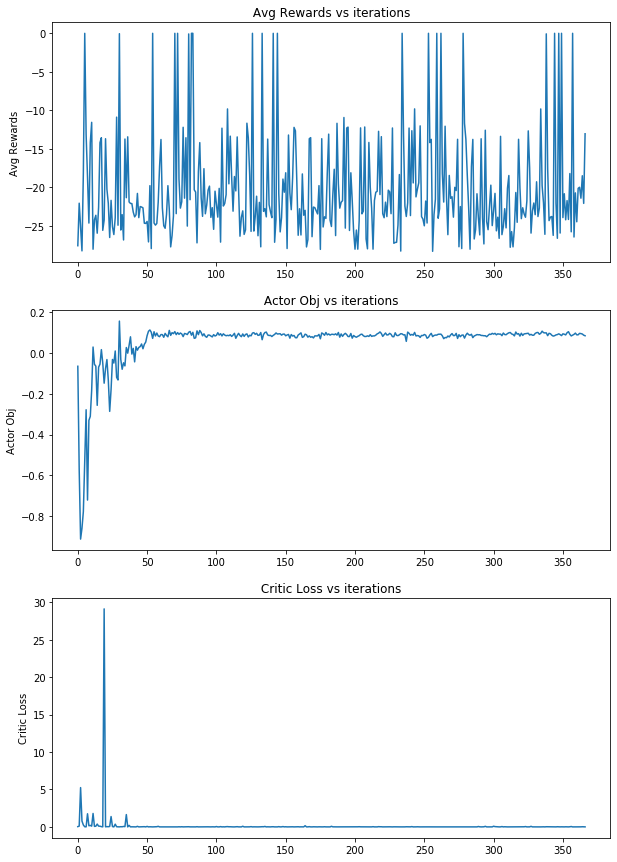

In [3]:
if plot:
    fig, axs = plt.subplots(3,1, figsize=(10,15))
    axs = axs.flatten()
    axs[0].plot(ddpg_object.avg_rewards)
    axs[0].set_ylabel('Avg Rewards')
    axs[0].set_title(' Avg Rewards vs iterations ')
    axs[1].plot(ddpg_object.obj_actor[::ddpg_object.ev_n_steps])
    axs[1].set_ylabel('Actor Obj')
    axs[1].set_title(' Actor Obj vs iterations ')
    axs[2].plot(ddpg_object.loss_critic[::ddpg_object.ev_n_steps])
    axs[2].set_ylabel('Critic Loss')
    axs[2].set_title(' Critic Loss vs iterations ')

In [4]:
ddpg_object.save_actor(3)